# GIQA Score

## Save degraded and restored images


In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import random

# Torch imports
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from ignite.metrics import PSNR, SSIM
from ignite.engine import *
from torchmetrics.image.kid import KernelInceptionDistance

# Import diffusion model
from pytorch_diffusion.diffusion import get_beta_schedule, Diffusion

# imports for plotting
import PIL
from skimage import io
import matplotlib.pyplot as plt
from IPython.display import Image

# For progess bar
from tqdm import tqdm

# Costum imports
from utils.degradation import Degradation, UniformBlur, Noising, SuperResolution
from utils.data_utils import plot_batches, set_device, eval_step
from utils.ddrm import DDRM

import cv2 as cv

import numpy as np
import re



# Set device
device = set_device()


Using device: mps:0


In [76]:
from torchvision.datasets.lsun import LSUN, LSUNClass
import torchvision.transforms as transforms
import torch
from tqdm import tqdm


In [153]:
# Initialise Hyperparameters
batch_size = 4
kernel_size=(9,9)
image_size=(256,256)
sr_kernel_size = 2
channels = 3

eta = 0.85
eta_b = 1
n_steps = 20
time_steps=1000

std = 0.1
debug_mode = False
save_images = True

In [155]:
# Define metrics for evaluation of model performance
default_evaluator = Engine(eval_step)

# PSNR Score
psnr = PSNR(data_range=1, device='cpu')
psnr.attach(default_evaluator, 'psnr')

# SSIM Score
ssim = SSIM(data_range=1, kernel_size=kernel_size)
ssim.attach(default_evaluator, 'ssim')

## Super Resolution

In [78]:
degradation_model = SuperResolution(device=device,
                                    std=std,
                                    kernel_size=sr_kernel_size,
                                    image_size=image_size[0],
                                    channels = channels
                                    )


In [79]:
data_dir = './data/cats/'

data = ImageFolder(
    root=data_dir,
    transform=transforms.Compose([
        transforms.PILToTensor(),
        transforms.Resize(image_size),
        ])
)

data_loader = DataLoader(
    data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

print(f'Length of Dataset: {data.__len__()}')
print(f'Length of DataLoader: {data_loader.__len__()}')

Length of Dataset: 50
Length of DataLoader: 12


In [80]:
name = "lsun_cat"
# name = "lsun_church"
# name = "image_net"

diffusion = DDRM.from_pretrained(name, device=device, num_timesteps=time_steps)
hyperparams = dict(sigma_y = std, eta = eta, eta_b =  eta_b, n_steps = n_steps)

resize = transforms.Resize(size=image_size)


Instantiating
Using device mps
Loading checkpoint /Users/Pipo/Downloads/diffusion_model_ckpt/cache/diffusion_models_converted/diffusion_lsun_cat_model/model-1761000.ckpt
Moved model to mps


In [156]:
# Run evaluation of model

# Save batches for plots
save_every_steps = 0
sample_batches_for_plots_noiseless = []


# Lists for storing scores of baseline
psnr_baseline, ssim_baseline = [], []

# Lists for storing scores of DDRM
psnr_ddrm, ssim_ddrm = [], []

k = 0
for i, batch in enumerate(tqdm(data_loader)):
  batch = (batch[0]/255).to(device)

  if batch.shape[0] != batch_size:
    continue

  # Degrade the sample
  degraded_batch = degradation_model(batch)


  # Denoise and deblurr the sample
  reconstructed, steps = diffusion.denoise(batch_size,
                              degraded_batch,
                              n_steps=n_steps,
                              degradation_model = degradation_model,
                              hyperparams=hyperparams)


  y = resize(batch).cpu()
  y_degraded = resize(degraded_batch).cpu()
  y_pred = reconstructed.cpu()

  # Save batches save_every_steps steps
  if save_every_steps==0:
    sample_batches_for_plots_noiseless.append([batch, degraded_batch, reconstructed])
  elif (i%save_every_steps)==0:
    sample_batches_for_plots_noiseless.append([batch, degraded_batch, reconstructed])


  if debug_mode:
    # plot and break for debugging
    plot_batches([batch, degraded_batch, reconstructed])
    break

  
  # Compute PSNR and SSID, then append to score lists
  state_baseline = default_evaluator.run([[y, y_degraded]])
  psnr_baseline.append(state_baseline.metrics['psnr'])
  ssim_baseline.append(state_baseline.metrics['ssim'])

  state_ddrm = default_evaluator.run([[y, y_pred]])
  psnr_ddrm.append(state_ddrm.metrics['psnr'])
  ssim_ddrm.append(state_ddrm.metrics['ssim'])

  # Save degraded and reconstructed images in folder
  if save_images:
    y = y.permute(0,2,3,1)
    y = cv.normalize(y.numpy(), None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

    y_degraded = y_degraded.permute(0,2,3,1)
    y_degraded = cv.normalize(y_degraded.numpy(), None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

    y_pred = y_pred.permute(0,2,3,1)
    y_pred_normalized = cv.normalize(y_pred.numpy(), None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)
    
    for j in range(batch_size):
      io.imsave(f'./data/giqa/cats/{k}_original.png', y[j])
      io.imsave(f'./data/giqa/cats/{k}_degraded.png', y_degraded[j])
      io.imsave(f'./data/giqa/cats/{k}_restored.png', y_pred_normalized[j])
      # io.imsave(f'./data/giqa/cats/{k}_restored_shifted.png', y_pred_shifted[j])
      k += 1



100%|██████████| 12/12 [03:32<00:00, 17.73s/it]


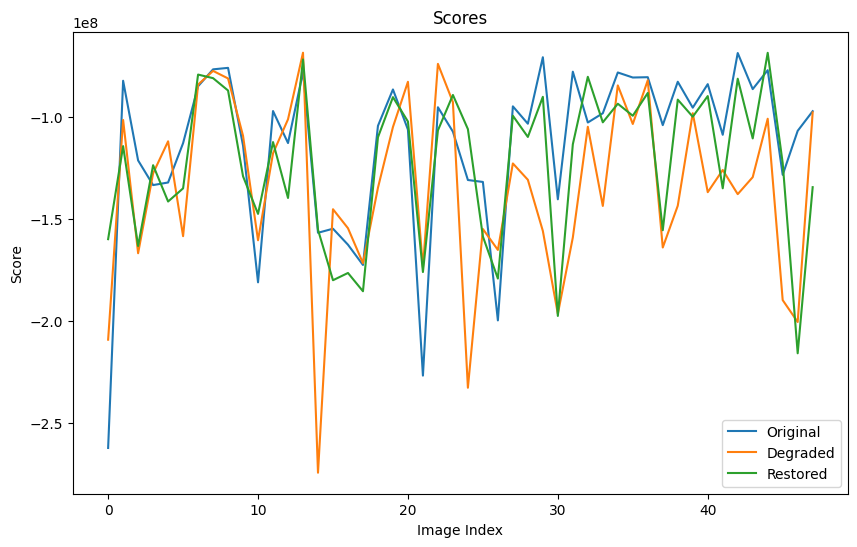

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(48, 3)
[-1.22505739e+08 -2.15977810e+08 -1.34338084e+08]
[array([-2.62500503e+08, -8.20496936e+07, -1.21196967e+08]), array([-1.33316523e+08, -1.32042661e+08, -1.12716830e+08]), array([-84742986.8474213 , -76442015.79674113, -75709335.90433286]), array([-1.13911114e+08, -1.81107721e+08, -9.69279952e+07]), array([-1.12658227e+08, -7.77281543e+07, -1.56753067e+08]), array([-1.54758101e+08, -1.62619872e+08, -1.72572068e+08]), array([-1.04205900e+08, -8.63221802e+07, -1.06050608e+08]), array([-2.26951011e+08, -9.50645825e+07, -1.07051722e+08]), array([-1.30820806e+08, -1.31773920e+08, -1.99813872e+08]), array([-9.46234235e+07, -1.03154138e+08, -7.04954255e+07]), array([-1.40297796e+08, -7.75888476e+07, -1.02565390e+08]), array([-98015867.16604057, -77975978.82706718, -80452715.56043406]), array([-8.02987566e+07, -1.03850960e+08, -8.25366126e+07]), array([-9.52762741e+07, -8.37151061e+07, -1.08599843e+08]), array([-68418487.30847614, -86154987.73710425, -76847621.27631755]), array([-1.2827

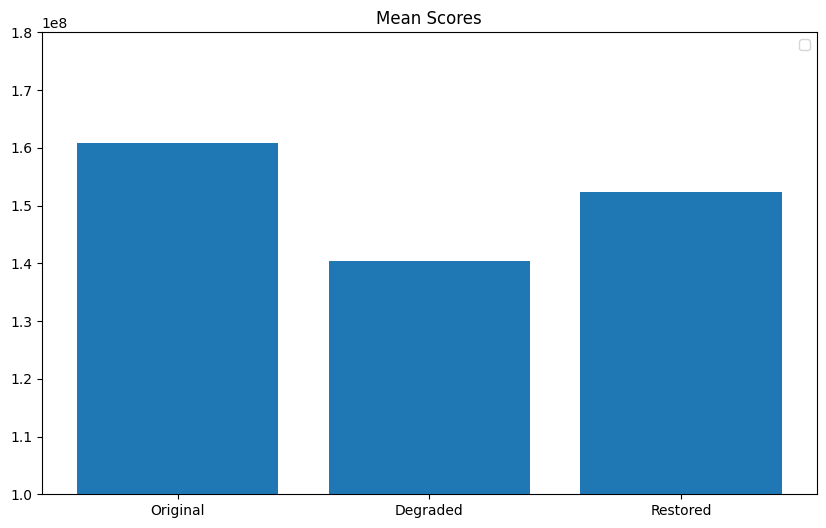

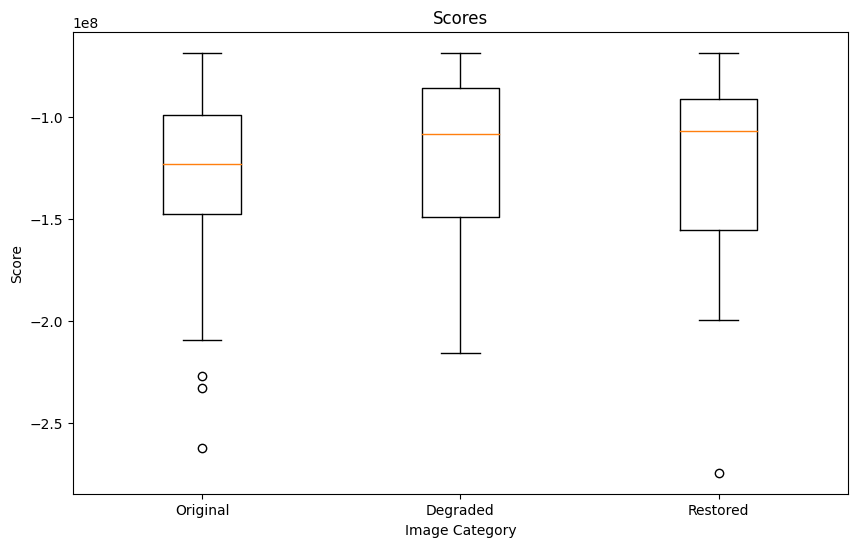

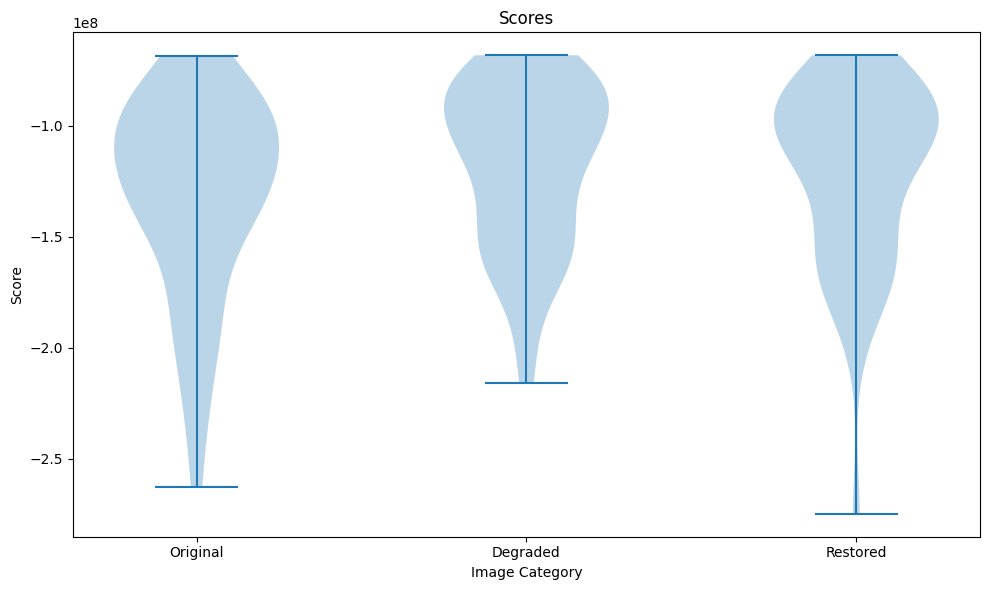

In [211]:

# Read the data from the text file
with open('results.txt', 'r') as file:
    data = file.read()

# Extract scores using regular expressions
scores = re.findall(r'score of (\d+)_(\w+).png is:\n(-?\d+\.\d+)', data)

# Create dictionaries to store original, degraded, and restored scores
original_scores = {}
degraded_scores = {}
restored_scores_normalized = {}
restored_scores_shifted = {}

# Organize scores according to their index
for score in scores:
    index, label, value = score
    # print(index, label, value)
    if label == 'original':
        original_scores.setdefault(int(index), []).append(float(value))
    elif label == 'degraded':
        degraded_scores.setdefault(int(index), []).append(float(value))
    elif label == 'restored':
        restored_scores_normalized.setdefault(int(index), []).append(float(value))
    # elif label == 'restored_shifted':
    #     restored_scores_shifted.setdefault(int(index), []).append(float(value))
    

# Create lists for mean and standard deviation of each score category
# original_scores = []
# degraded_scores = []
# restored_scores = []
# Sort scores according to their index
original_scores = dict(sorted(original_scores.items()))
degraded_scores = dict(sorted(degraded_scores.items()))
restored_scores_normalized = dict(sorted(restored_scores_normalized.items()))
# restored_scores_shifted = dict(sorted(restored_scores_shifted.items()))

# Sort all scores according to increasing values of the original scores
# original_scores = dict(sorted(original_scores.items(), key=lambda item: item[1]))
# degraded_scores = {k: degraded_scores[k] for k in sorted(original_scores)}
# restored_scores_normalized = {k: restored_scores_normalized[k] for k in sorted(original_scores)}

# Plotting original, degraded, and restored scores in same plot
indices = list(range(len(original_scores)))
plt.figure(figsize=(10, 6))
plt.plot(indices, list(original_scores.values()), label='Original')
plt.plot(indices, list(degraded_scores.values()), label='Degraded')
plt.plot(indices, list(restored_scores_normalized.values()), label='Restored')
# plt.plot(indices, list(restored_scores_shifted.values()), label='Restored Shifted')
plt.xlabel('Image Index')
plt.ylabel('Score')
plt.title('Scores')
plt.legend()
plt.show()



# Plotting mean and standard deviation of each score category
plt.figure(figsize=(10, 6))

original_mean = np.mean(list(original_scores.values()))-np.min(list(degraded_scores.values()))
# original_std_dev = np.std(list(original_scores.values()))
degraded_mean = np.mean(list(degraded_scores.values()))-np.min(list(degraded_scores.values()))
# degraded_std_dev = np.std(list(degraded_scores.values()))
restored_normalized_mean = np.mean(list(restored_scores_normalized.values()))-np.min(list(degraded_scores.values()))
# restored_normalized_std_dev = np.std(list(restored_scores_normalized.values()))
# restored_shifted_mean = np.mean(list(restored_scores_shifted.values()))
# restored_shifted_std_dev = np.std(list(restored_scores_shifted.values()))

# plt.bar(['Original', 'Degraded', 'Restored'], [original_mean, degraded_mean, restored_normalized_mean], yerr=[original_std_dev, degraded_std_dev, restored_normalized_std_dev])
# set y bar limits
plt.ylim(1e8, 1.8e8)
plt.bar(['Original', 'Degraded', 'Restored'], [original_mean, degraded_mean, restored_normalized_mean])
plt.title('Mean Scores')
plt.legend()

# Plot in boxplot
plt.figure(figsize=(10, 6))
boxplot_data = np.array([list(original_scores.values()), list(degraded_scores.values()), list(restored_scores_normalized.values())]).reshape(-1,3)
print(boxplot_data.shape)
print(boxplot_data[-1])
print(list(boxplot_data))

plt.boxplot(boxplot_data)
plt.title('Scores')
plt.xticks([1, 2, 3], ['Original', 'Degraded', 'Restored'])
plt.ylabel('Score')
plt.xlabel('Image Category')

# Plot in violinplot
plt.figure(figsize=(10, 6))
plt.violinplot(boxplot_data)
plt.title('Scores')
plt.xticks([1, 2, 3], ['Original', 'Degraded', 'Restored'])
plt.ylabel('Score')
plt.xlabel('Image Category')

plt.tight_layout()
plt.show()

print("")

In [215]:
degraded_ratio = np.array(list(degraded_scores.values()))/np.array(list(original_scores.values()))
restored_ratio = np.array(list(restored_scores_normalized.values()))/np.array(list(original_scores.values()))


print('-------------------| Original |-------------------')
print(f'# Samples: {len(list(original_scores.values()))}')
print(f"Mean GIQA score for original images: {original_mean/original_mean:.0%}")

print('-------------------| Degraded |-------------------')
print(f'# Samples: {len(list(degraded_scores.values()))}')
# print(f"Mean GIQA: {degraded_mean/original_mean}")
print(f'Mean GIQA: {2-np.mean(degraded_ratio):.0%}')
print(f'Mean PSNR: {sum(psnr_baseline)/len(psnr_baseline)}')
print(f'Mean SSIM: {sum(ssim_baseline)/len(ssim_baseline)}')


print('-------------------| Restored Normalized |-------------------')
print(f'# Samples: {len(list(restored_scores_normalized.values()))}')
# print(f"Mean GIQA: {2-restored_normalized_mean/original_mean:.0%}")
print(f'Mean GIQA: {2-np.mean(restored_ratio):.0%}')
print(f'Mean PSNR: {sum(psnr_ddrm)/len(psnr_ddrm)}')
print(f'Mean SSIM: {sum(ssim_ddrm)/len(ssim_ddrm)}')

print('-------------------| Restored Shifted |-------------------')
print(f'# Samples: {len(list(restored_scores_shifted.values()))}')
# print(f"Mean GIQA score for restored images: {2-restored_shifted_mean/original_mean:.0%}")

# print('---------------------| DDRM |---------------------')
# print(f'Mean PSNR: {sum(psnr_ddrm)/len(psnr_ddrm)}')
# print(f'Mean SSIM: {sum(ssim_ddrm)/len(ssim_ddrm)}')

-------------------| Original |-------------------
# Samples: 48
Mean GIQA score for original images: 100%
-------------------| Degraded |-------------------
# Samples: 48
77%
Mean PSNR: 23.09635981982774
Mean SSIM: 0.42447717327545
-------------------| Restored Normalized |-------------------
# Samples: 48
89%
Mean PSNR: 28.30784301922559
Mean SSIM: 0.7758156065063152
-------------------| Restored Shifted |-------------------
# Samples: 0


In [189]:
np.min(list(restored_scores_normalized.values()))

min = np.min([np.min(list(degraded_scores.values())), np.min(list(original_scores.values())), np.min(list(restored_scores_normalized.values()))])
max = np.max([np.max(list(degraded_scores.values())), np.max(list(original_scores.values())), np.max(list(restored_scores_normalized.values()))])
print(min, max)

normalized_original_mean = (original_mean-min)/(max-min)
normalized_degraded_mean = (degraded_mean-min)/(max-min)
normalized_restored_mean = (restored_normalized_mean-min)/(max-min)

print(f'Normalized mean GIQA score for original images: {normalized_original_mean/normalized_original_mean}')
print(f'Normalized mean GIQA score for degraded images: {normalized_degraded_mean/normalized_original_mean}')
print(f'Normalized mean GIQA score for restored images: {normalized_restored_mean/normalized_original_mean}')

-274669811.4297407 -68269441.54182835
Normalized mean GIQA score for original images: 1.0
Normalized mean GIQA score for degraded images: 0.8730115378704293
Normalized mean GIQA score for restored images: 0.9463860944150478


0.6338167673764549


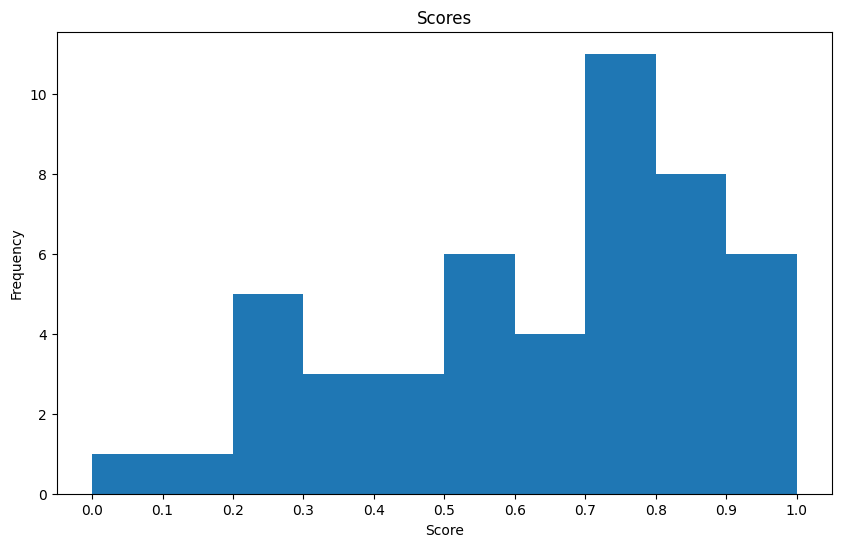

46
44


In [198]:
min = np.min(list(restored_scores_normalized.values()))
max = np.max(list(restored_scores_normalized.values()))

restored = (np.array(list(restored_scores_normalized.values()))-min)/(max-min)

print(np.mean(restored))
# create bar plot with quantiles of 0.1 step size for restored images
plt.figure(figsize=(10, 6))
plt.hist(restored, bins=np.arange(0, 1.1, 0.1))
plt.title('Scores')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

# show a sample of an image in lowest quantile, 0.5 quantile and highest quantile
# lowest quantile
index = np.argmin(restored)
print(index)

index = np.argmax(restored)
print(index)

# 


0.6805872658384061


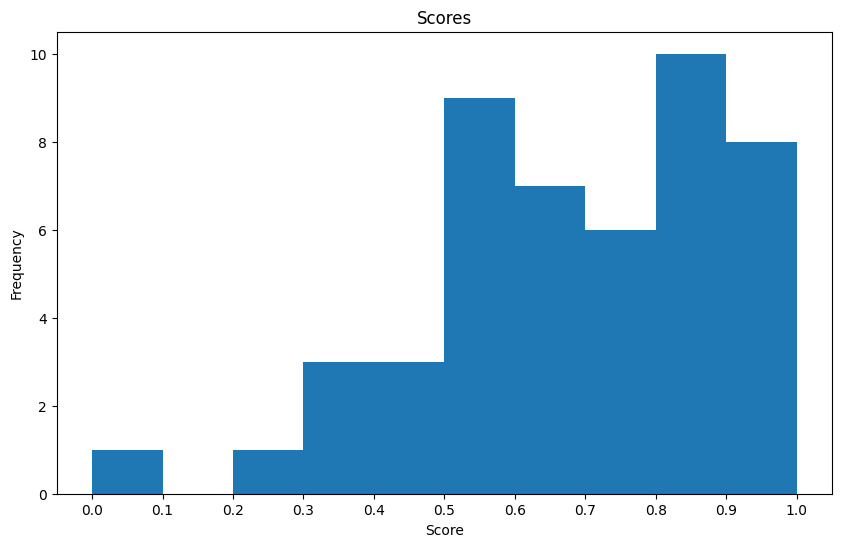

In [199]:
min = np.min(list(degraded_scores.values()))
max = np.max(list(degraded_scores.values()))

degraded = (np.array(list(degraded_scores.values()))-min)/(max-min)

print(np.mean(degraded))
# create bar plot with quantiles of 0.1 step size for restored images
plt.figure(figsize=(10, 6))
plt.hist(degraded, bins=np.arange(0, 1.1, 0.1))
plt.title('Scores')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()
